[Chainer v2 でSmoothGradを実装](http://qiita.com/hogemon/items/cdff53174dd89034d18d) を後追い実験

In [1]:
import chainer
import chainer.functions as F
from chainer.variable import Variable
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#テストモード、バックプロパゲーションあり

chainer.config.train=False
chainer.config.enable_backprop=True

model = VGG16Layers()

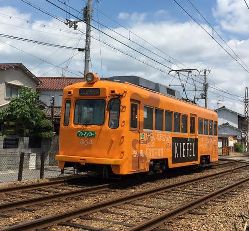

In [3]:
img = Image.open("train.jpg")
img.resize(np.array(img.size)//2)  # 画像の確認（ハーフサイスで表示している）

In [18]:
image = VGGprepare(img)
sampleSize = 20
noiseLevel = 20 # 20%
sigma = noiseLevel*55.0  #255

In [19]:
gradList = []
for _ in range(sampleSize):
    x = image.reshape(1,3,224,224)
    # ノイズを追加
    x += sigma*np.random.randn(1,3,224,224)    
    x = Variable(np.asarray(x))
    # FPして最終層を取り出す
    y = model(x, layers=['prob'])['prob']
    # 予測が最大のラベルでBP
    t = np.zeros((1),dtype=np.int32)
    t[:] = np.argmax(y.data)
    t = Variable(np.asarray(t))
    loss = F.softmax_cross_entropy(y,t)
    loss.backward()
    # 勾配をリストに追加
    grad = np.copy(x.grad)
    gradList.append(grad)
    # 勾配をクリア
    model.cleargrads()

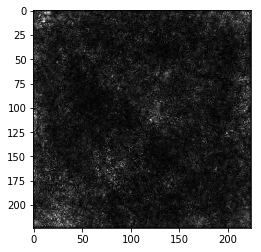

In [20]:
G = np.array(gradList)
M = np.mean(np.max(np.abs(G),axis=2),axis=0)
M = np.squeeze(M)
plt.imshow(M,"gray")
plt.show()